**작성자: 컴퓨터정보과 3-A 202044008 박준형**

**제목: 인천지하철 1호선 일별 승하차현황**

이 프로젝트를 실행하기 전 먼저 한글 깨짐 방지를 위해 폰트를 설치해 준 다음 런타임을 재시작합니다.

In [ ]:
# 폰트 설치
import matplotlib.font_manager as fm
!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

#런타임 재시작
import os
os.kill(os.getpid(), 9)

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

In [ ]:
# 필수 라이브러리 먼저 설치
%pip install prophet
%pip install plotly

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# thousands 변수 사용 이유
# 1000단위마다 ,가 들어 있을 경우 object로 인식되기 떄문
# 한글 처리를 위해 인코딩은 CP949로
data_metro = pd.read_csv('/content/인천교통공사_1호선_일별_승하차현황_2021년.csv', encoding='cp949', thousands=',')

data_metro = data_metro.set_index('일자')
data_metro.isna().sum()

slot_data = data_metro.iloc[:,2:].sum()

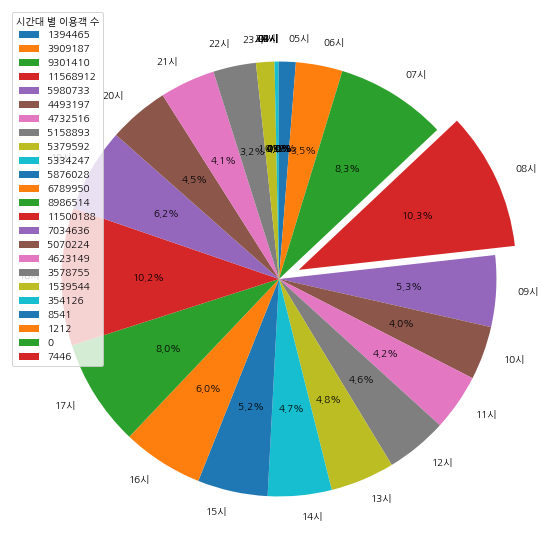

In [15]:
plt.figure(figsize=(10,10))
explode = (0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(slot_data, labels = slot_data.index, explode = explode , autopct='%1.1f%%', startangle = 90, counterclock = False)
plt.legend(slot_data,
           loc="best",
          title ="시간대 별 이용객 수")

plt.show()

plot를 통해 시간대 별 총 이용 승객 수를 집계합니다.

In [ ]:
plt.figure(figsize = (12,7))
plt.plot(slot_data, '.-')
plt.title('시간대 별 총 이용 승객수')
plt.xlabel('시간대')
plt.ylabel('승객 수')
plt.show()

Plot 차트 예시입니다. 이 Plot 차트는 승차객 수를 집계합니다.

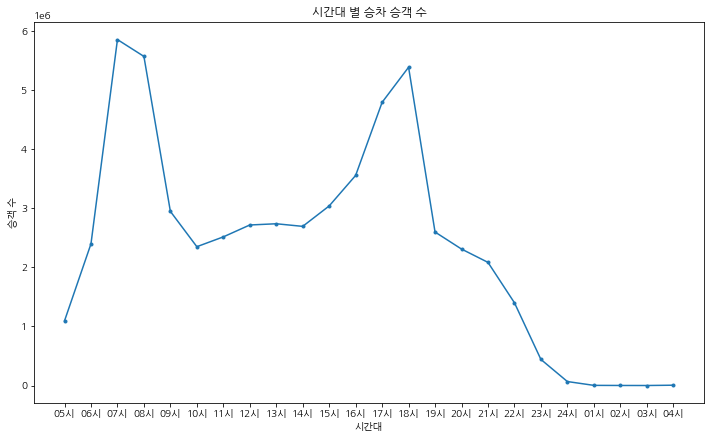

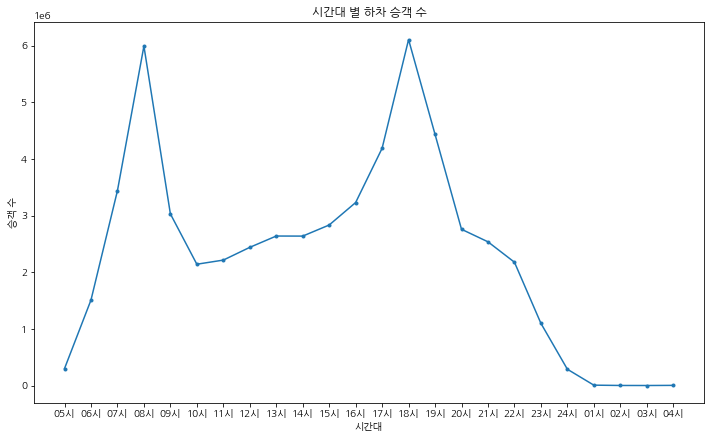

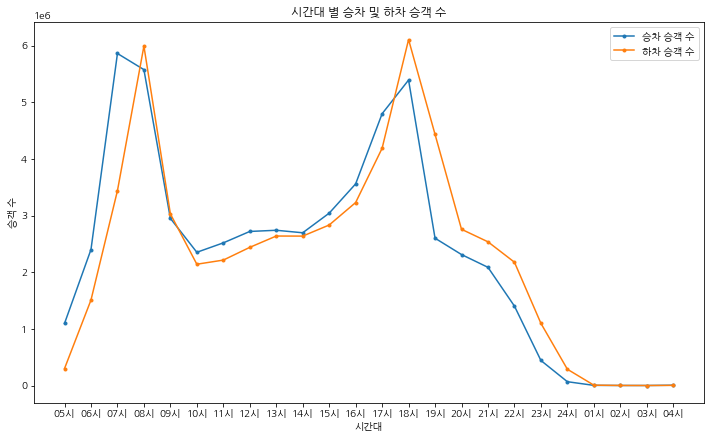

In [14]:
# 승차객 수
passenger_ride = data_metro.loc[data_metro['구분']=='승차']
passenger_ride = passenger_ride.drop(['구분','계'], axis=1)
passenger_ride.head()
passenger_ride = passenger_ride.sum()

plt.figure(figsize = (12,7))
plt.plot(passenger_ride, '.-')
plt.title('시간대 별 승차 승객 수')
plt.xlabel('시간대')
plt.ylabel('승객 수')
plt.show()

# 하차객 수
passenger_off = data_metro.loc[data_metro['구분'] == '하차']
passenger_off = passenger_off.drop(['구분','계'], axis=1)
passenger_off = passenger_off.sum()

plt.figure(figsize = (12,7))
plt.plot(passenger_off, '.-')
plt.title('시간대 별 하차 승객 수')
plt.xlabel('시간대')
plt.ylabel('승객 수')
plt.show()

# 승차 승객과 하차 승객의 수를 비교
plt.figure(figsize = (12,7))
plt.plot(passenger_ride, '.-', label = '승차 승객 수')
plt.plot(passenger_off, '.-', label = '하차 승객 수')
plt.title('시간대 별 승차 및 하차 승객 수')
plt.xlabel('시간대')
plt.ylabel('승객 수')
plt.legend()
plt.show()

Prophet 을 통해 학습시키고 365일치의 예측을 진행합니다.

In [11]:
from prophet import Prophet

fb_metro = data_metro.reset_index()
fb_metro['일자'] = pd.to_datetime(fb_metro['일자'])
fb_metro.info()

fb_passenger_ride = fb_metro.loc[fb_metro['구분']=='승차']
fb_passenger_off = fb_metro.loc[fb_metro['구분']=='하차']

ride = fb_passenger_ride.iloc[:,[0,2]].set_index('일자')
off = fb_passenger_off.iloc[:,[0,2]].set_index('일자')

total = ride + off

total = total.reset_index()

total = total.rename(columns = {'일자':'ds', '계':'y'})
total
total.info()
total.isna().sum()

m = Prophet()
m.fit(total)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일자      730 non-null    datetime64[ns]
 1   구분      730 non-null    object        
 2   계       730 non-null    int64         
 3   05시     730 non-null    int64         
 4   06시     730 non-null    int64         
 5   07시     730 non-null    int64         
 6   08시     730 non-null    int64         
 7   09시     730 non-null    int64         
 8   10시     730 non-null    int64         
 9   11시     730 non-null    int64         
 10  12시     730 non-null    int64         
 11  13시     730 non-null    int64         
 12  14시     730 non-null    int64         
 13  15시     730 non-null    int64         
 14  16시     730 non-null    int64         
 15  17시     730 non-null    int64         
 16  18시     730 non-null    int64         
 17  19시     730 non-null    int64         
 18  20시     73

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5p8mdrc/m65xxfg6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5p8mdrc/w5vwojyx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88616', 'data', 'file=/tmp/tmpk5p8mdrc/m65xxfg6.json', 'init=/tmp/tmpk5p8mdrc/w5vwojyx.json', 'output', 'file=/tmp/tmpk5p8mdrc/prophet_modelbt5n40fl/prophet_model-20221211113957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:39:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:39:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,265444.664694,267017.714133,354921.645076,265444.664694,265444.664694,45614.316793,45614.316793,45614.316793,45614.316793,45614.316793,45614.316793,0.0,0.0,0.0,311058.981487
1,2021-01-02,266078.530986,162915.589835,254083.863454,266078.530986,266078.530986,-58177.795204,-58177.795204,-58177.795204,-58177.795204,-58177.795204,-58177.795204,0.0,0.0,0.0,207900.735782
2,2021-01-03,266712.397278,100203.617076,188367.719818,266712.397278,266712.397278,-123439.444742,-123439.444742,-123439.444742,-123439.444742,-123439.444742,-123439.444742,0.0,0.0,0.0,143272.952536
3,2021-01-04,267346.263571,245512.116942,333762.367356,267346.263571,267346.263571,22523.429040,22523.429040,22523.429040,22523.429040,22523.429040,22523.429040,0.0,0.0,0.0,289869.692611
4,2021-01-05,267980.129863,260719.896482,348605.785307,267980.129863,267980.129863,35698.257829,35698.257829,35698.257829,35698.257829,35698.257829,35698.257829,0.0,0.0,0.0,303678.387692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2022-12-27,429137.251387,358957.755146,579842.852547,328370.051043,527822.229752,35698.257829,35698.257829,35698.257829,35698.257829,35698.257829,35698.257829,0.0,0.0,0.0,464835.509217
726,2022-12-28,429407.041664,356467.874904,571199.263354,328231.202861,528676.074686,37662.448157,37662.448157,37662.448157,37662.448157,37662.448157,37662.448157,0.0,0.0,0.0,467069.489821
727,2022-12-29,429676.831941,358962.605862,575525.595460,327952.921758,529346.405303,40118.788127,40118.788127,40118.788127,40118.788127,40118.788127,40118.788127,0.0,0.0,0.0,469795.620069
728,2022-12-30,429946.622219,363081.454681,589872.111464,327727.128828,530011.755036,45614.316793,45614.316793,45614.316793,45614.316793,45614.316793,45614.316793,0.0,0.0,0.0,475560.939012


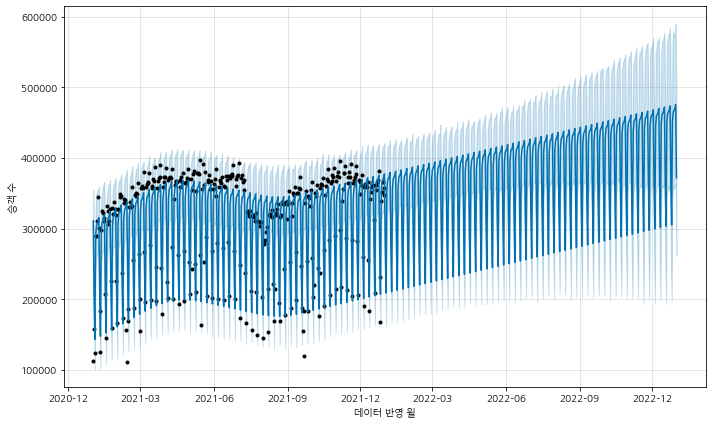

In [12]:
m.plot(forecast, xlabel = '데이터 반영 월', ylabel = '승객 수')
plt.show()

다음은 예측을 진행해 출력된 결과입니다. 2021년 자료이기 때문에 2022년 12월 이후까지의 승객 수의 추이를 예측하였습니다.

미세하게 우상향하고 있는 것을 관찰할 수 있습니다.

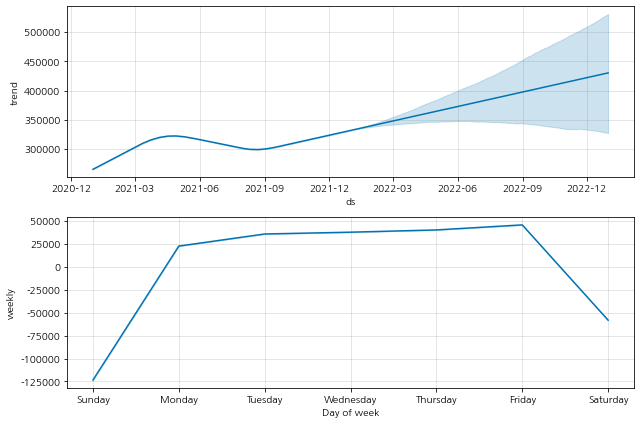

In [13]:
m.plot_components(forecast)
plt.show()